35/35 [==============================] - 9s 258ms/step
Sample 0: Predicted vs Actual Labels
Predicted: 0.0212, Actual: 0.0506
Predicted: 0.1131, Actual: 0.9290
Predicted: 0.0000, Actual: 0.0000
Predicted: 0.3049, Actual: 0.9910
Predicted: 0.0914, Actual: 0.1689
Predicted: 0.1042, Actual: 0.0000
Predicted: 0.0999, Actual: 0.0128
Predicted: 0.0520, Actual: 0.0000
Predicted: 0.0559, Actual: 0.0000
Predicted: 0.0682, Actual: 0.0000
Predicted: 0.0725, Actual: 0.0000
Predicted: 0.2357, Actual: 1.0000
Predicted: 0.0769, Actual: 0.0000
Predicted: 0.0813, Actual: 0.0340
Predicted: 0.2772, Actual: 0.4456
Predicted: 0.0857, Actual: 0.0000
Predicted: 0.2972, Actual: 0.7357
Predicted: 0.0902, Actual: 0.0000
Predicted: 0.3184, Actual: 0.9426
Predicted: 0.0948, Actual: 0.0000
Predicted: 0.0794, Actual: 1.0000
Predicted: 0.3416, Actual: 0.3314
Predicted: 0.3658, Actual: 0.8939
Predicted: 0.1042, Actual: 0.0911
Predicted: 0.3898, Actual: 0.8757
Predicted: 0.1088, Actual: 0.0000
Predicted: 0.0906, Actua

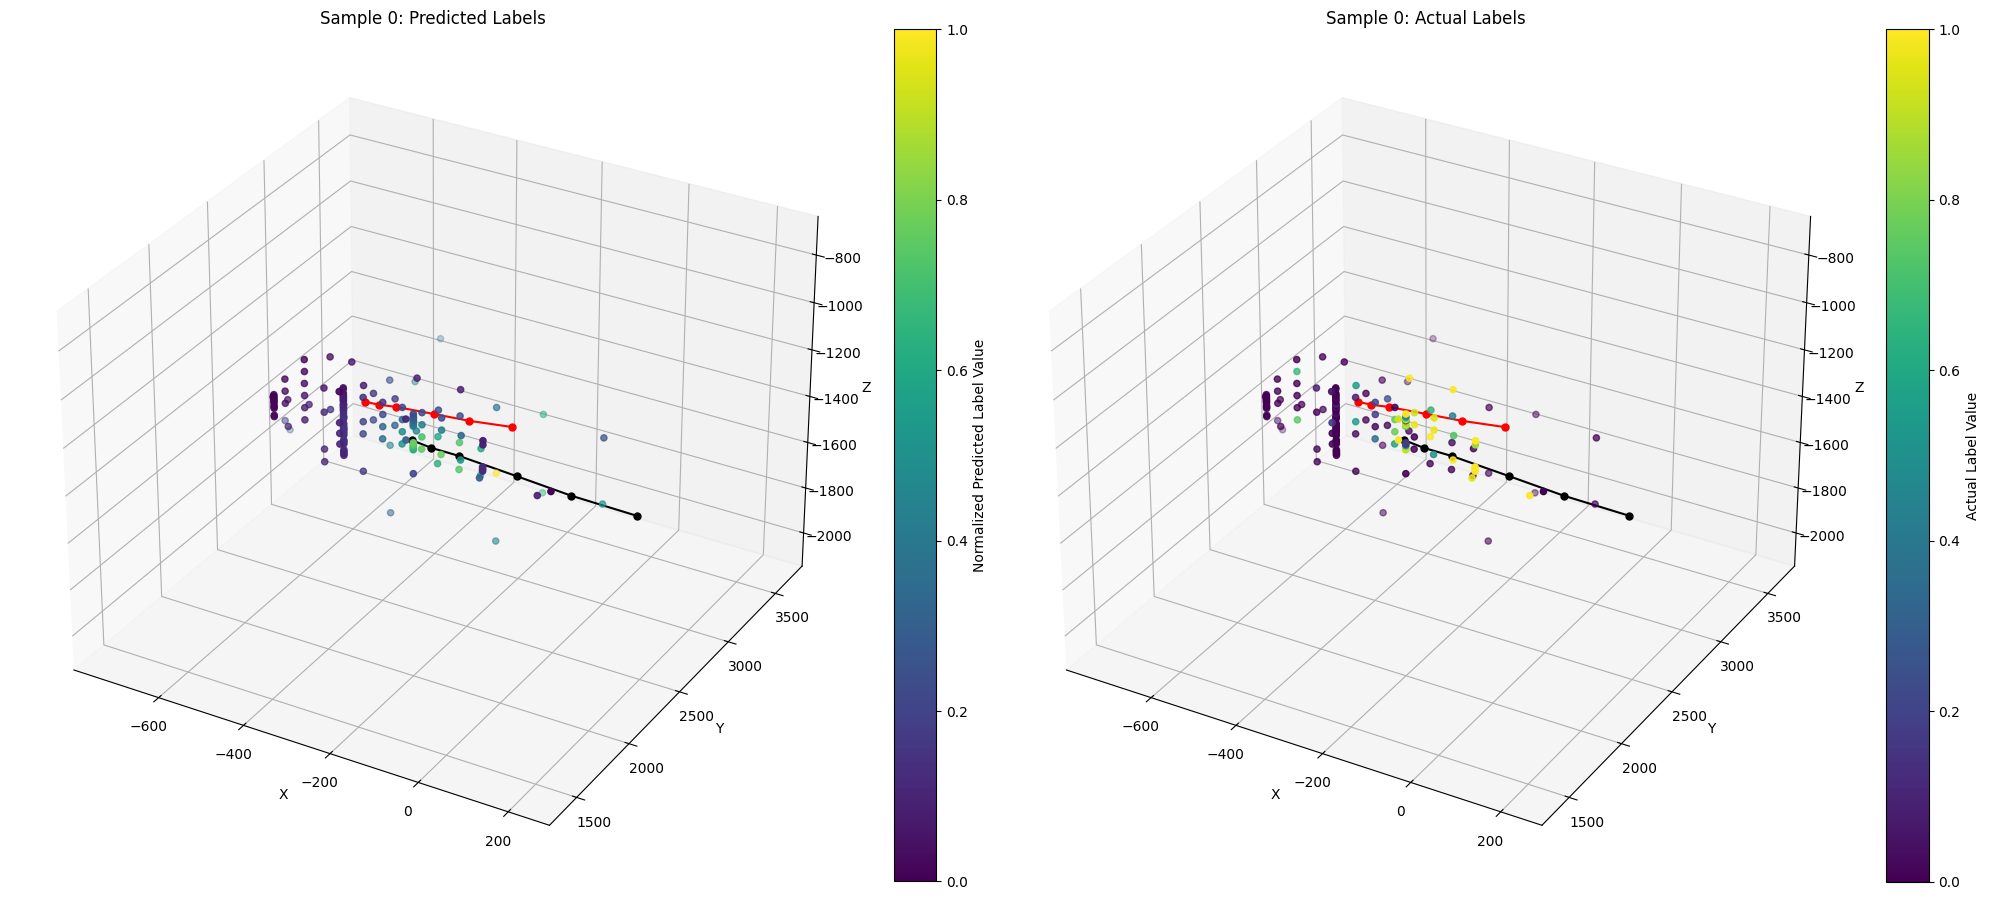

Sample 1: Predicted vs Actual Labels
Predicted: 0.0000, Actual: 0.0000
Predicted: 0.0000, Actual: 0.0000
Predicted: 0.0000, Actual: 0.0000
Predicted: 0.0001, Actual: 0.0000
Predicted: 0.0036, Actual: 0.0000
Predicted: 0.1992, Actual: 0.0000
Predicted: 0.1294, Actual: 0.0000
Predicted: 0.1369, Actual: 0.0000
Predicted: 0.0682, Actual: 0.0000
Predicted: 0.0085, Actual: 0.0000
Predicted: 0.0000, Actual: 0.0000
Predicted: 0.0001, Actual: 0.0000
Predicted: 0.0001, Actual: 0.0000
Predicted: 0.0000, Actual: 0.0000
Predicted: 0.0001, Actual: 0.0000
Predicted: 0.0000, Actual: 0.0000
Predicted: 0.0002, Actual: 0.0000
Predicted: 0.0000, Actual: 0.0000
Predicted: 0.0002, Actual: 0.0000
Predicted: 0.0000, Actual: 0.0000
Predicted: 0.0000, Actual: 0.0000
Predicted: 0.0007, Actual: 0.0000
Predicted: 0.0000, Actual: 0.0000
Predicted: 0.0018, Actual: 0.0000
Predicted: 0.0001, Actual: 0.0000
Predicted: 0.0042, Actual: 0.0000
Predicted: 0.0001, Actual: 0.0000
Predicted: 0.0088, Actual: 0.0000
Predicted: 

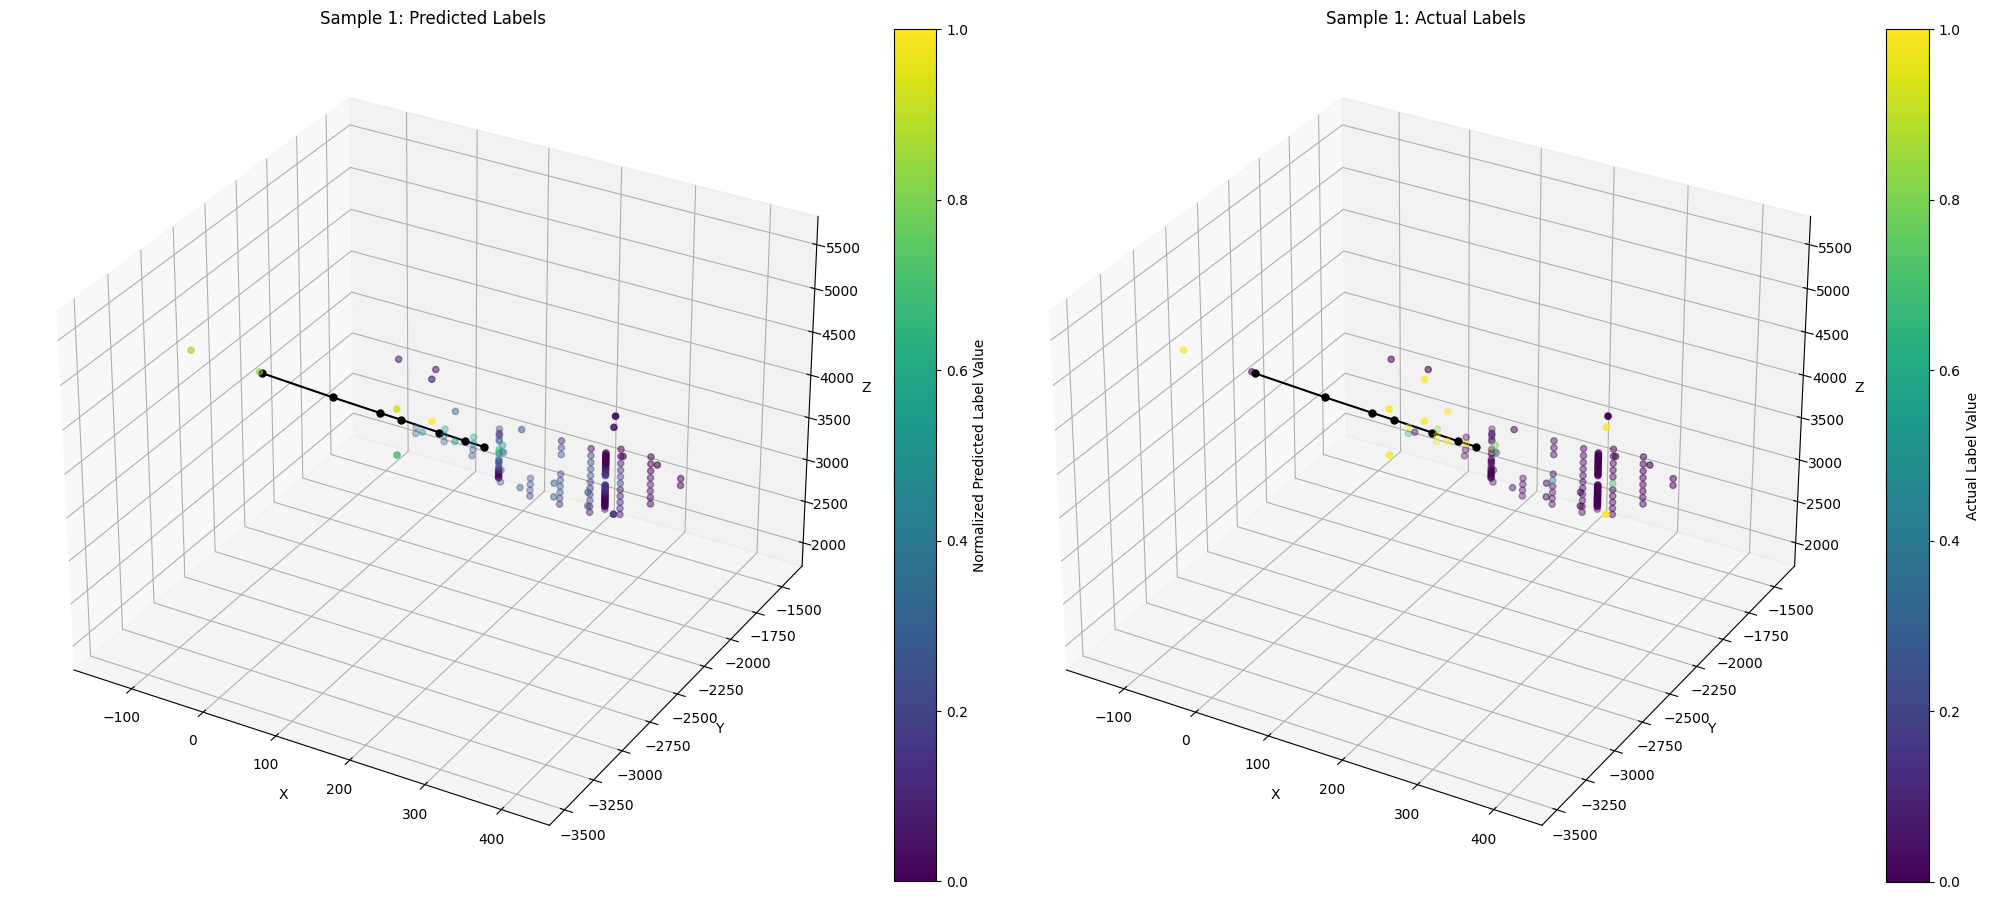

Sample 2: Predicted vs Actual Labels
Predicted: 0.0000, Actual: 1.0000
Predicted: 0.0273, Actual: 0.9917
Predicted: 0.0923, Actual: 0.0035
Predicted: 0.0574, Actual: 0.0149
Predicted: 0.0497, Actual: 0.0000
Predicted: 0.0372, Actual: 0.0019
Predicted: 0.2916, Actual: 0.0000
Predicted: 0.2397, Actual: 0.0000
Predicted: 0.1805, Actual: 0.0000
Predicted: 0.1329, Actual: 0.0000
Predicted: 0.5893, Actual: 0.0000
Predicted: 0.4080, Actual: 0.0000
Predicted: 1.0000, Actual: 0.0000


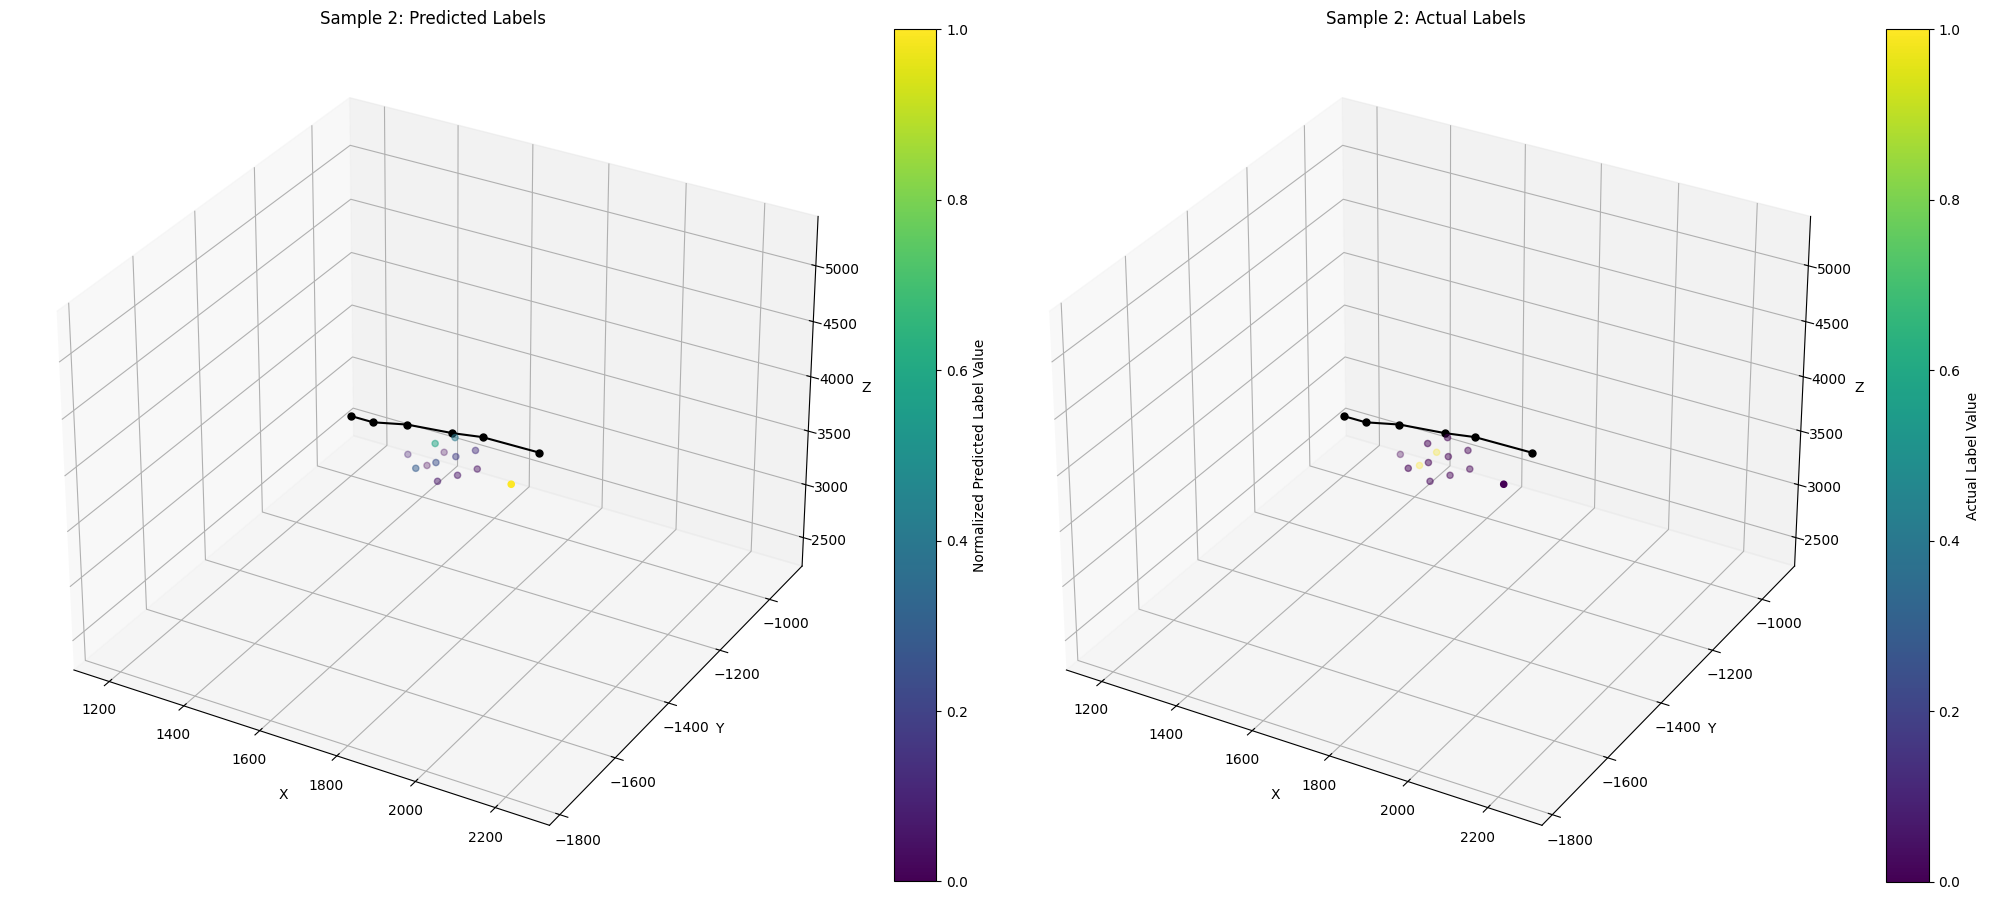

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import glob
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from models.JetPointNet import PointNetSegmentation

os.environ['CUDA_VISIBLE_DEVICES'] = ""  # Disable GPU

def load_data_from_npz(npz_file):
    data = np.load(npz_file)
    feats = data['feats']
    labels = data['labels']
    return feats, labels

model = PointNetSegmentation(num_points=859, num_classes=1)
model.load_weights("saved_model/PointNetModel.keras")
TEST_DIR = '/data/mjovanovic/jets/processed_files/2000_events_w_fixed_hits/SavedNpz/test'

npz_files = glob.glob(os.path.join(TEST_DIR, '*.npz'))
feats, labels = load_data_from_npz(npz_files[0])

predicted_labels = np.squeeze(model.predict(feats), axis=-1)

for sample_index in range(len(feats)):
    indcs = np.where(labels[sample_index] != -1)
    current_labels = labels[sample_index]
    current_predicted_labels = predicted_labels[sample_index]

    # Normalize predictions for each sample
    min_pred = np.min(current_predicted_labels[indcs])
    max_pred = np.max(current_predicted_labels[indcs])
    normalized_predictions = (current_predicted_labels - min_pred) / (max_pred - min_pred)

    print(f"Sample {sample_index}: Predicted vs Actual Labels")
    for pred, actual in zip(normalized_predictions[indcs], current_labels[indcs]):
        print(f"Predicted: {pred:.4f}, Actual: {actual:.4f}")

    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(121, projection='3d')
    ax.set_title(f'Sample {sample_index}: Predicted Labels')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    ax2 = fig.add_subplot(122, projection='3d')
    ax2.set_title(f'Sample {sample_index}: Actual Labels')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')

    current_feats = feats[sample_index]
    x, y, z, types = current_feats[:, 0], current_feats[:, 1], current_feats[:, 2], current_feats[:, 5]
    
    # Adjust the "other types mask"
    other_types_mask = types == 0  # Updated mask

    # Plotting
    for type_val, color in zip([1, 2], ['k', 'r']):
        type_mask = types == type_val
        if np.any(type_mask):
            ax.plot(x[type_mask], y[type_mask], z[type_mask], color=color, linestyle='-', marker='o', markersize=5)
            ax2.plot(x[type_mask], y[type_mask], z[type_mask], color=color, linestyle='-', marker='o', markersize=5)
    
    # Use normalized predictions for colors in the predictions plot
    if np.any(other_types_mask):
        sc = ax.scatter(x[other_types_mask], y[other_types_mask], z[other_types_mask], 
                        c=normalized_predictions[other_types_mask], cmap='viridis', marker='o')
        sc2 = ax2.scatter(x[other_types_mask], y[other_types_mask], z[other_types_mask], 
                          c=current_labels[other_types_mask], cmap='viridis', marker='o')

        # Color bars for the scatter plots
        cbar = fig.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label('Normalized Predicted Label Value')
        cbar2 = fig.colorbar(sc2, ax=ax2, fraction=0.046, pad=0.04)
        cbar2.set_label('Actual Label Value')

    plt.tight_layout()
    plt.show()

    if sample_index == 25:  # Adjust this as needed
        break
